In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scipy.stats as stats


In [5]:
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
combined_features = RDKit_feature_names + mdfp_features_no_2d
mdfp_features = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI', 'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']


In [6]:
data_full = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/mdfp_and_rdkit_features_augmented.csv')
mdfps = data_full['mdfp'].tolist()
mdfps = [eval(mdfp) for mdfp in mdfps]
for i,key in enumerate(mdfp_features):
    data_full[key] = [mdfps[j][i] for j in range(len(mdfps))]
print(len(data_full))
data_full['mdfp'] = mdfps

14003


In [7]:
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
mdfp_features_no_2d = ['water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median', 'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']
combined_features = RDKit_feature_names + mdfp_features_no_2d
#make feature vectors of RDKit_feature_names by combining column values of RDKit_feature_names in data_full
feature_vectors_physchem = []
feature_vectors_combined = []
for i in range(len(data_full)):
    feature_vector_physchem = []
    feature_vector_combined = []
    for feature in RDKit_feature_names:
        feature_vector_physchem.append(data_full[feature][i])
        feature_vector_combined.append(data_full[feature][i])
    for feature in mdfp_features_no_2d:
        feature_vector_combined.append(data_full[feature][i])
    feature_vectors_physchem.append(feature_vector_physchem)
    feature_vectors_combined.append(feature_vector_combined)
data_full['PhysChem_vector'] = feature_vectors_physchem
data_full['Combined_vector'] = feature_vectors_combined

In [10]:
data_full_unique = data_full.drop_duplicates(subset=['molregno'])
print(len(data_full_unique))

2980


In [11]:
def checks(train,test):
    #check if there is overlap in molregnos between train and test
    train_molregnos = train['molregno'].to_numpy()
    test_molregnos = test['molregno'].to_numpy()

    overlap = np.intersect1d(train_molregnos, test_molregnos)
    if len(overlap) > 0:
        print(f"Overlap in molregnos between train and test, exiting...")
        return False

    ratio_train = len(train)/len(train+test)
    ratio_test = len(test)/len(train+test)
    if ratio_train < 0.75 or ratio_train > 0.85:
        print(f"Train fraction is {ratio_train}, exiting...")
        False
    return True


In [51]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
outputs = ([],[],[],[],[],[],[],[],[],[],[])
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
X = data_full_unique['molregno'].to_numpy()
output = ([],[],[],[],[],[])
params = {
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
} #hyperparameters optimized for augmented dataset
for i, (train_index, test_index) in enumerate(rkf.split(X)):
    train_all = data_full[data_full['molregno'].isin(X[train_index])]
    test_all = data_full[data_full['molregno'].isin(X[test_index])]

    #then we make a seperate set with only one conformer per molregno
    molregnos_train = train_all['molregno'].tolist()
    molregnos_test = test_all['molregno'].tolist()
    confids_train = train_all['confid'].tolist()
    confids_test = test_all['confid'].tolist()


    train_y = np.array(train_all['vp_log10pa'].tolist())
    test_y = np.array(test_all['vp_log10pa'].tolist())

    train_x_mdfp = np.array(train_all['mdfp'].tolist())
    test_x_mdfp = np.array(test_all['mdfp'].tolist())

    train_x_physchem = np.array(train_all['PhysChem_vector'].tolist())
    test_x_physchem = np.array(test_all['PhysChem_vector'].tolist())

    train_x_combined = np.array(train_all['Combined_vector'].tolist())
    test_x_combined = np.array(test_all['Combined_vector'].tolist())

    scaler_physchem = StandardScaler()
    scaler_physchem.fit(train_x_physchem)
    train_x_physchem = scaler_physchem.transform(train_x_physchem)
    test_x_physchem = scaler_physchem.transform(test_x_physchem)

    scaler_combined = StandardScaler()
    scaler_combined.fit(train_x_combined)
    train_x_combined = scaler_combined.transform(train_x_combined)
    test_x_combined = scaler_combined.transform(test_x_combined)

    dtrain_mdfp = xgb.DMatrix(train_x_mdfp, label=train_y)
    dtest_mdfp = xgb.DMatrix(test_x_mdfp, label=test_y)

    dtrain_physchem = xgb.DMatrix(train_x_physchem, label=train_y)
    dtest_physchem = xgb.DMatrix(test_x_physchem, label=test_y)

    dtrain_combined = xgb.DMatrix(train_x_combined, label=train_y)
    dtest_combined = xgb.DMatrix(test_x_combined, label=test_y)


    model_mdfp = xgb.train(
        params,
        dtrain_mdfp,
        num_boost_round=999,
        evals=[(dtest_mdfp, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    model_physchem = xgb.train(
        params,
        dtrain_physchem,
        num_boost_round=999,
        evals=[(dtest_physchem, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    model_combined = xgb.train(
        params,
        dtrain_combined,
        num_boost_round=999,
        evals=[(dtest_combined, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False
    )

    preds_mdfp = model_mdfp.predict(dtest_mdfp)
    preds_physchem = model_physchem.predict(dtest_physchem)
    preds_combined = model_combined.predict(dtest_combined)


    outputs[0].append(preds_mdfp)
    outputs[1].append(preds_physchem)
    outputs[2].append(preds_combined)
    outputs[3].append(test_y)
    outputs[4].append(molregnos_test)
    outputs[5].append(confids_test)



    #check overlap train and test molregno
    if len(set(molregnos_train).intersection(set(molregnos_test))) != 0:
        print('overlap between train and test molregnos')
        break

    #print the RMSEs
    rmse_mdfp = mean_squared_error(test_y, preds_mdfp, squared=False)
    rmse_physchem = mean_squared_error(test_y, preds_physchem, squared=False)
    rmse_combined = mean_squared_error(test_y, preds_combined, squared=False)
    print(f"Fold {i + 1}: MDFP RMSE = {rmse_mdfp}, physchem RMSE = {rmse_physchem}, combined RMSE = {rmse_combined}")
#save outputs as pickle
import pickle
with open('output_physchem.pkl', 'wb') as f:
    pickle.dump(outputs, f)

Fold 1: MDFP RMSE = 1.4837353606579693, physchem RMSE = 1.273126054148538, combined RMSE = 1.295806926488944
Fold 2: MDFP RMSE = 1.292392226284654, physchem RMSE = 1.1548234620456477, combined RMSE = 1.178552638869894
Fold 3: MDFP RMSE = 1.5004038613602877, physchem RMSE = 1.209974486379183, combined RMSE = 1.226436283215807
Fold 4: MDFP RMSE = 1.2658042310526563, physchem RMSE = 1.0646095220811835, combined RMSE = 1.102183434477562
Fold 5: MDFP RMSE = 1.4633998462126037, physchem RMSE = 1.376772314689016, combined RMSE = 1.3795970111232438
Fold 6: MDFP RMSE = 1.317387326993871, physchem RMSE = 1.2642697912295104, combined RMSE = 1.228824233198465
Fold 7: MDFP RMSE = 1.6184198198302244, physchem RMSE = 1.2927215212008123, combined RMSE = 1.2901378478882637
Fold 8: MDFP RMSE = 1.410061958820521, physchem RMSE = 1.2523820301925324, combined RMSE = 1.2566035260074218
Fold 9: MDFP RMSE = 1.4023450658690946, physchem RMSE = 1.3014820059557723, combined RMSE = 1.2879361777758696
Fold 10: MDF

FileNotFoundError: [Errno 2] No such file or directory: '/localhome/cschiebroek/MDFPs/mdfptools/carl/Experiments_result_analysis/outputs/outputs_5fold_3rep_augmented.pkl'

In [112]:
with open('output_physchem.pkl', 'rb') as f:
    outputs = pickle.load(f)

In [113]:
preds_mdfp_nested = outputs[0]
preds_physchem_nested = outputs[1]
preds_combined_nested = outputs[2]
y_test_nested = outputs[3]
molregnos_test_nested = outputs[4]
confids_test_nested = outputs[5]

df_template = pd.DataFrame({'Prediction': [], 'Experimental': [], 'molregno': [], 'confid': [], 'fold': []})
df_mdfp = df_template.copy()
df_2d = df_template.copy()
df_combined = df_template.copy()

for fold in range(len(y_test_nested)):
    df_mdfp = pd.concat([df_mdfp, pd.DataFrame({'Prediction': preds_mdfp_nested[fold], 'Experimental': y_test_nested[fold], 'molregno': molregnos_test_nested[fold], 'confid': confids_test_nested[fold], 'fold': fold})])
    df_2d = pd.concat([df_2d, pd.DataFrame({'Prediction': preds_physchem_nested[fold], 'Experimental': y_test_nested[fold], 'molregno': molregnos_test_nested[fold], 'confid': confids_test_nested[fold], 'fold': fold})])
    df_combined = pd.concat([df_combined, pd.DataFrame({'Prediction': preds_combined_nested[fold], 'Experimental': y_test_nested[fold], 'molregno': molregnos_test_nested[fold], 'confid': confids_test_nested[fold], 'fold': fold})])

/tmp/ipykernel_24467/2781719610.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mdfp = pd.concat([df_mdfp, pd.DataFrame({'Prediction': preds_mdfp_nested[fold], 'Experimental': y_test_nested[fold], 'molregno': molregnos_test_nested[fold], 'confid': confids_test_nested[fold], 'fold': fold})])
/tmp/ipykernel_24467/2781719610.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2d = pd.concat([df_2d, pd.DataFrame({'Prediction': preds_physchem_nested[fold], 'Experimental': y_test_nested[fo

In [116]:
df_mdfp.sort_values(by=['molregno', 'confid'], inplace=True)
df_mdfp

,Prediction,Experimental,molregno,confid,fold
236,4.274829,4.100855,1.0,2298.0,1.0
227,3.997701,4.100855,1.0,2298.0,9.0
218,4.313746,4.100855,1.0,2298.0,14.0
1175,4.302417,4.100855,1.0,7191.0,1.0
1203,4.004694,4.100855,1.0,7191.0,9.0
...,...,...,...,...,...
2241,-1.772636,5.397940,4244.0,12583.0,5.0
2157,-1.443463,5.397940,4244.0,12583.0,14.0
2178,-1.703528,5.397940,4244.0,12584.0,2.0
2245,-1.786041,5.397940,4244.0,12584.0,5.0


making 3 plots
plot 1 of 3
2980 points
plot 2 of 3
2980 points
plot 3 of 3
2980 points


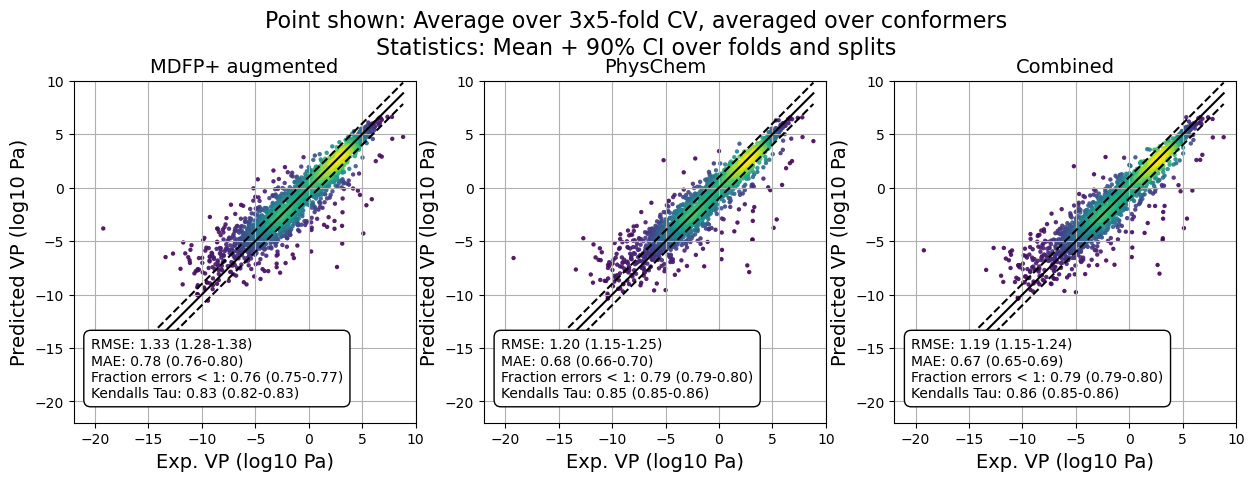

In [59]:

#make nested lists for pred and real, nested by split index
preds_mdfp_nested, preds_2d_nested, preds_combined_nested = [], [], []
test_y_mdfp_nested, test_y_2d_nested, test_y_combined_nested = [], [], []
molregnos_mdfp_nested, molregnos_2d_nested, molregnos_combined_nested = [], [], []

for i in range(len(y_test_nested)):
    df_preds_mdfp_split = df_mdfp[df_mdfp['fold'] == i].groupby('molregno').mean()
    df_preds_2d_split = df_2d[df_2d['fold'] == i].groupby('molregno').mean()
    df_preds_combined_split = df_combined[df_combined['fold'] == i].groupby('molregno').mean()

    preds_mdfp = df_preds_mdfp_split['Prediction'].tolist()
    preds_2d = df_preds_2d_split['Prediction'].tolist()
    preds_combined = df_preds_combined_split['Prediction'].tolist()

    test_mdfp = df_preds_mdfp_split['Experimental'].tolist()
    test_2d = df_preds_2d_split['Experimental'].tolist()
    test_combined = df_preds_combined_split['Experimental'].tolist()

    molregnos_mdfp = df_preds_mdfp_split.index.tolist()
    molregnos_2d = df_preds_2d_split.index.tolist()
    molregnos_combined = df_preds_combined_split.index.tolist()


    preds_mdfp_nested.append(preds_mdfp)
    preds_2d_nested.append(preds_2d)
    preds_combined_nested.append(preds_combined)

    test_y_mdfp_nested.append(test_mdfp)
    test_y_2d_nested.append(test_2d)
    test_y_combined_nested.append(test_combined)

    molregnos_mdfp_nested.append(molregnos_mdfp)
    molregnos_2d_nested.append(molregnos_2d)
    molregnos_combined_nested.append(molregnos_combined)



pred_nested = [preds_mdfp_nested, preds_2d_nested, preds_combined_nested]
real_nested = [test_y_mdfp_nested, test_y_2d_nested, test_y_combined_nested]
molregnos_nested = [molregnos_mdfp_nested, molregnos_2d_nested, molregnos_combined_nested]
titles = ['MDFP+ augmented','PhysChem','Combined']
density_plot_multiple_custom(real_nested, pred_nested, molregnos=molregnos_nested,titles=titles,bounds = [-22,10], print_stats=False,global_title="Point shown: Average over 3x5-fold CV, averaged over conformers\nStatistics: Mean + 90% CI over folds and splits", name = 'Physchem')


In [138]:
fold_indices = []
groups = data_full['molregno']
params_one = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
params_many = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
# Iterate over each fold
outputs = ([],[],[],[],[],[],[],[],[],[],[])
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
X = data_full_unique['molregno'].to_numpy()
output = ([],[],[],[],[],[])
params = {
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
} #hyperparameters optimized for augmented dataset
for i, (train_index, test_index) in enumerate(rkf.split(X)):

    train_all = data_full[data_full['molregno'].isin(X[train_index])]
    test_all = data_full[data_full['molregno'].isin(X[test_index])]

    #then we make a seperate set with only one conformer per molregno
    molregnos_train_unique = train_all['molregno'].unique().tolist()
    molregnos_test_unique = test_all['molregno'].unique().tolist()

    #check overlap train and test molregno
    if len(set(molregnos_train_unique).intersection(set(molregnos_test_unique))) != 0:
        print('overlap between train and test molregnos')
        break

    confids_train = []
    for molregno in molregnos_train_unique:
        confids = train_all[train_all['molregno'] == molregno]['confid'].tolist()
        confids_train.append(np.random.choice(confids, 1)[0])
    train_one_to_one = train_all[train_all['confid'].isin(confids_train)].copy()

    confids_test_one = []
    confids_test_many = test_all['confid'].tolist()
    for molregno in molregnos_test_unique:
        confids = test_all[test_all['molregno'] == molregno]['confid'].tolist()       
        confids_test_one.append(np.random.choice(confids, 1)[0])
    test_one_to_one = test_all[test_all['confid'].isin(confids_test_one)].copy()
    
    confids_test_one = test_one_to_one['confid'].tolist()
    molregnos_test_one = test_one_to_one['molregno'].tolist()

    train_x_one = np.array(train_one_to_one['mdfp'].tolist())
    train_y_one = np.array(train_one_to_one['vp_log10pa'].tolist())
    dtrain_one = xgb.DMatrix(train_x_one, label=train_y_one)
    
    test_x_one = np.array(test_one_to_one['mdfp'].tolist())
    test_y_one = np.array(test_one_to_one['vp_log10pa'].tolist())
    dtest_one = xgb.DMatrix(test_x_one, label=test_y_one)

    train_x_many = np.array(train_all['mdfp'].tolist())
    train_y_many = np.array(train_all['vp_log10pa'].tolist())
    dtrain_many = xgb.DMatrix(train_x_many, label=train_y_many)

    test_x_many = np.array(test_all['mdfp'].tolist())
    test_y_many = np.array(test_all['vp_log10pa'].tolist())
    dtest_many = xgb.DMatrix(test_x_many, label=test_y_many)




    #now for all four, train models and predict
    model_one = xgb.train(
        params_one,
        dtrain_one,
        num_boost_round=999,
        verbose_eval=False
    )
    model_many = xgb.train(
        params_many,
        dtrain_many,
        num_boost_round=999,
        verbose_eval=False
    )
    preds_one_to_one = model_one.predict(dtest_one)
    preds_many_to_many = model_many.predict(dtest_many)

    preds_one_to_many = model_one.predict(dtest_many)
    preds_many_to_one = model_many.predict(dtest_one)

    outputs[0].append(preds_one_to_one)
    outputs[1].append(preds_many_to_many)
    outputs[2].append(preds_one_to_many)
    outputs[3].append(preds_many_to_one)

    outputs[4].append(test_y_one)
    outputs[5].append(test_y_many)

    confids_test_all = test_all['confid'].tolist()
    molregnos_test_all = test_all['molregno'].tolist()

    outputs[6].append(molregnos_test_one)
    outputs[7].append(molregnos_test_all)

    outputs[8].append(confids_test_one)
    outputs[9].append(confids_test_all)

    #check output lengths: all 'many' should be equal and all 'one' should be equal
    if len(preds_one_to_one) != len(preds_many_to_one) != len(test_y_one) != len(molregnos_test_unique) != len(confids_test_one):
        print('lengths not equal')
        print(len(preds_one_to_one), len(preds_many_to_one), len(test_y_one), len(molregnos_test_unique), len(confids_test_one))
        break
    if len(preds_many_to_many) != len(preds_one_to_many) != len(test_y_many) != len(molregnos_test_unique) != len(confids_test_many):
        print('lengths not equal')
        print(len(preds_many_to_many), len(preds_one_to_many), len(test_y_many), len(molregnos_test_unique), len(confids_test_many))
        break

    #print the RMSEs
    rmse_one_to_one = mean_squared_error(test_y_one, preds_one_to_one, squared=False)
    rmse_many_to_many = mean_squared_error(test_y_many, preds_many_to_many, squared=False)
    rmse_one_to_many = mean_squared_error(test_y_many, preds_one_to_many, squared=False)
    rmse_many_to_one = mean_squared_error(test_y_one, preds_many_to_one, squared=False)
    print(f"Fold {i + 1}: 1:1 RMSE = {rmse_one_to_one}, M:M RMSE = {rmse_many_to_many}, 1:M RMSE = {rmse_one_to_many}, M:1 RMSE = {rmse_many_to_one}")

with open('augmentation.pkl', 'wb') as f:
    pickle.dump(outputs, f)

Fold 1: 1:1 RMSE = 1.4848184600023626, M:M RMSE = 1.479871601639347, 1:M RMSE = 1.5596729557416666, M:1 RMSE = 1.3873848776864497
Fold 2: 1:1 RMSE = 1.2836442018393932, M:M RMSE = 1.2906223006765059, 1:M RMSE = 1.3832165395600131, M:1 RMSE = 1.2161642026903323
Fold 3: 1:1 RMSE = 1.419530043589875, M:M RMSE = 1.4975964266420743, 1:M RMSE = 1.5041969485064317, M:1 RMSE = 1.425990580900912
Fold 4: 1:1 RMSE = 1.4125990347200104, M:M RMSE = 1.2624050543416923, 1:M RMSE = 1.4383952724126914, M:1 RMSE = 1.2600877913177249
Fold 5: 1:1 RMSE = 1.456005923693146, M:M RMSE = 1.4598822592182334, 1:M RMSE = 1.5267603110953636, M:1 RMSE = 1.4075147117607787
Fold 6: 1:1 RMSE = 1.3240089512392896, M:M RMSE = 1.3159838763053022, 1:M RMSE = 1.391835890694424, M:1 RMSE = 1.2718548522561919
Fold 7: 1:1 RMSE = 1.481593436013687, M:M RMSE = 1.6165541755922839, 1:M RMSE = 1.5108456237901295, M:1 RMSE = 1.5570568618904035
Fold 8: 1:1 RMSE = 1.3367399580127064, M:M RMSE = 1.4098011880573296, 1:M RMSE = 1.439489

In [139]:
#load outputs
with open('augmentation.pkl', 'rb') as f:
    outputs = pickle.load(f)

In [140]:
preds_one_to_one_nested = outputs[0]
preds_many_to_many_nested = outputs[1]
preds_one_to_many_nested = outputs[2]
preds_many_to_one_nested = outputs[3]
test_y_one_nested = outputs[4]
test_y_many_nested = outputs[5]
molregnos_test_one_nested = outputs[6]
molregnos_test_many_nested = outputs[7]
confids_test_one_nested = outputs[8]
confids_test_many_nested = outputs[9]

df_template = pd.DataFrame({'Prediction': [], 'Experimental': [], 'molregno': [], 'confid': [], 'fold': []})
df_one_to_one_splits = df_template.copy()
df_many_to_many_splits = df_template.copy()
df_one_to_many_splits = df_template.copy()
df_many_to_one_splits = df_template.copy()

for i in range(len(outputs[4])):
    df_one_to_one_splits = pd.concat([df_one_to_one_splits, pd.DataFrame({'Prediction': preds_one_to_one_nested[i], 'Experimental': test_y_one_nested[i], 'molregno': molregnos_test_one_nested[i], 'confid': confids_test_one_nested[i], 'fold': [i]*len(outputs[4][i])})], ignore_index=True)
    df_many_to_many_splits = pd.concat([df_many_to_many_splits, pd.DataFrame({'Prediction': preds_many_to_many_nested[i], 'Experimental': test_y_many_nested[i], 'molregno': molregnos_test_many_nested[i], 'confid': confids_test_many_nested[i], 'fold': [i]*len(outputs[5][i])})], ignore_index=True)
    df_one_to_many_splits = pd.concat([df_one_to_many_splits, pd.DataFrame({'Prediction': preds_one_to_many_nested[i], 'Experimental': test_y_many_nested[i], 'molregno': molregnos_test_many_nested[i], 'confid': confids_test_many_nested[i], 'fold': [i]*len(outputs[5][i])})], ignore_index=True)
    df_many_to_one_splits = pd.concat([df_many_to_one_splits, pd.DataFrame({'Prediction': preds_many_to_one_nested[i], 'Experimental': test_y_one_nested[i], 'molregno': molregnos_test_one_nested[i], 'confid': confids_test_one_nested[i], 'fold': [i]*len(outputs[4][i])})], ignore_index=True)

/tmp/ipykernel_24467/2149182261.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_one_to_one_splits = pd.concat([df_one_to_one_splits, pd.DataFrame({'Prediction': preds_one_to_one_nested[i], 'Experimental': test_y_one_nested[i], 'molregno': molregnos_test_one_nested[i], 'confid': confids_test_one_nested[i], 'fold': [i]*len(outputs[4][i])})], ignore_index=True)
/tmp/ipykernel_24467/2149182261.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_many_to_many_splits = pd.concat([df_many_to

596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
596 596 596 596
596 2783
15 15 15 15
15 15 15 15
making 4 plots
plot 1 of 4
2980 points
plot 2 of 4
2980 points
plot 3 of 4
2980 points
plot 4 of 4
2980 points


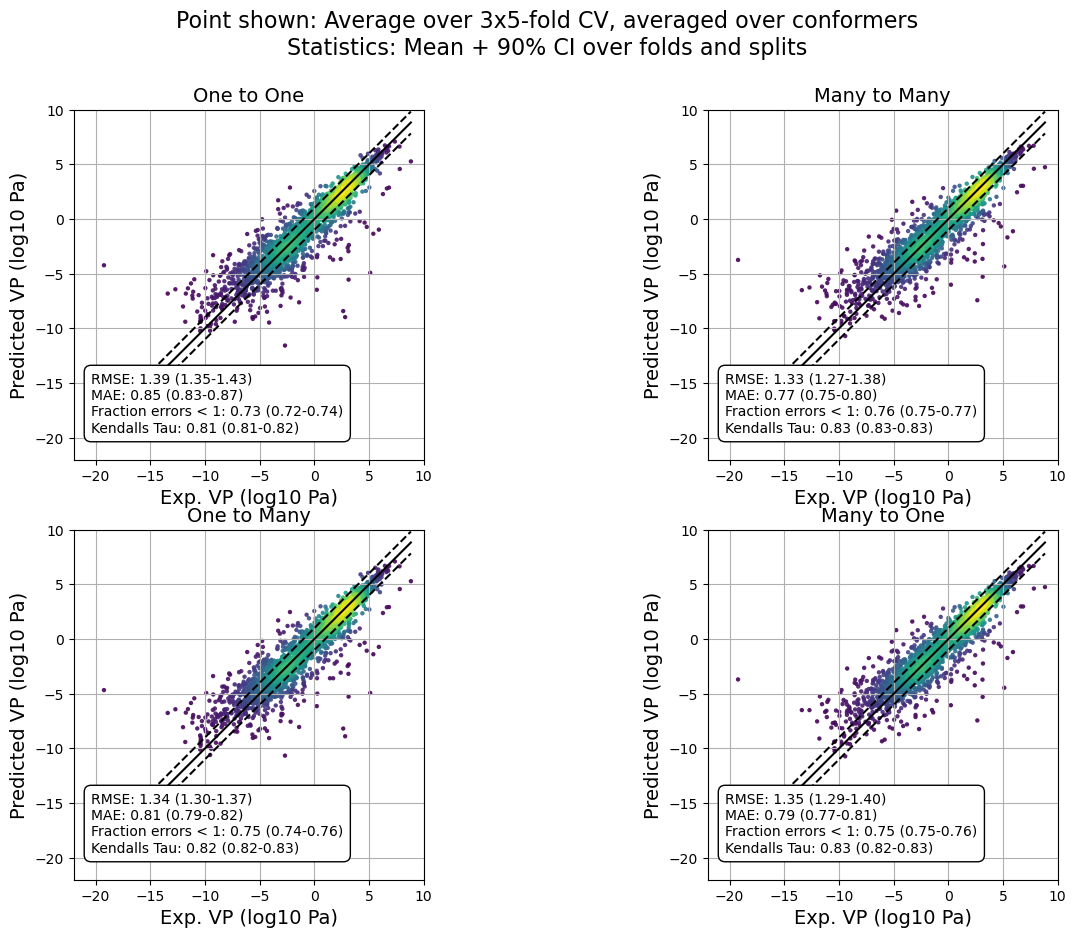

In [143]:
#make nested lists for pred and real, nested by split index
preds_one_to_one_nested, preds_many_to_many_nested, preds_one_to_many_nested, preds_many_to_one_nested = [], [], [], []
test_y_one_to_one_nested, test_y_many_to_many_nested, test_y_one_to_many_nested, test_y_many_to_one_nested = [], [], [], []

molregnos_one_to_one_nested, molregnos_many_to_many_nested, molregnos_one_to_many_nested, molregnos_many_to_one_nested = [], [], [], []
for i in range(15):
    df_preds_one_to_one = df_one_to_one_splits[df_one_to_one_splits['fold'] == i].groupby('molregno').mean()
    df_preds_many_to_many = df_many_to_many_splits[df_many_to_many_splits['fold'] == i].groupby('molregno').mean()
    df_preds_one_to_many = df_one_to_many_splits[df_one_to_many_splits['fold'] == i].groupby('molregno').mean()
    df_preds_many_to_one = df_many_to_one_splits[df_many_to_one_splits['fold'] == i].groupby('molregno').mean()

    preds_one_to_one = df_preds_one_to_one['Prediction'].tolist()
    preds_many_to_many = df_preds_many_to_many['Prediction'].tolist()
    preds_one_to_many = df_preds_one_to_many['Prediction'].tolist()
    preds_many_to_one = df_preds_many_to_one['Prediction'].tolist()

    test_one_to_one = df_preds_one_to_one['Experimental'].tolist()
    test_many_to_many = df_preds_many_to_many['Experimental'].tolist()
    test_one_to_many = df_preds_one_to_many['Experimental'].tolist()
    test_many_to_one = df_preds_many_to_one['Experimental'].tolist()

    molregnos_one_to_one = df_preds_one_to_one.index.tolist()
    molregnos_many_to_many = df_preds_many_to_many.index.tolist()
    molregnos_one_to_many = df_preds_one_to_many.index.tolist()
    molregnos_many_to_one = df_preds_many_to_one.index.tolist()

    preds_one_to_one_nested.append(preds_one_to_one)
    preds_many_to_many_nested.append(preds_many_to_many)
    preds_one_to_many_nested.append(preds_one_to_many)
    preds_many_to_one_nested.append(preds_many_to_one)

    molregnos_one_to_one_nested.append(molregnos_one_to_one)
    molregnos_many_to_many_nested.append(molregnos_many_to_many)
    molregnos_one_to_many_nested.append(molregnos_one_to_many)
    molregnos_many_to_one_nested.append(molregnos_many_to_one)

    print(len(preds_one_to_one), len(preds_many_to_many), len(preds_one_to_many), len(preds_many_to_one))

    test_y_one_to_one_nested.append(test_one_to_one)
    test_y_many_to_many_nested.append(test_many_to_many)
    test_y_one_to_many_nested.append(test_one_to_many)
    test_y_many_to_one_nested.append(test_many_to_one)

    print(len(test_y_one), len(test_y_many))
    

print(len(preds_one_to_one_nested),len(preds_many_to_one_nested),len(test_y_one_to_one_nested),len(test_y_many_to_many_nested))
print(len(preds_many_to_many_nested),len(preds_one_to_many_nested),len(test_y_many_to_many_nested),len(test_y_one_to_many_nested))

pred_nested = [preds_one_to_one_nested, preds_many_to_many_nested, preds_one_to_many_nested, preds_many_to_one_nested]
real_nested = [test_y_one_to_one_nested, test_y_many_to_many_nested, test_y_one_to_many_nested, test_y_many_to_one_nested]
molregnos_nested = [molregnos_one_to_one_nested, molregnos_many_to_many_nested, molregnos_one_to_many_nested, molregnos_many_to_one_nested]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple_custom(real_nested, pred_nested, titles=titles, molregnos=molregnos_nested,bounds = [-22,10], print_stats=False,global_title="Point shown: Average over 3x5-fold CV, averaged over conformers\nStatistics: Mean + 90% CI over folds and splits",name = 'augmentation')



In [144]:
molregnos_one_to_one_flat = [item for sublist in molregnos_one_to_one_nested for item in sublist]
preds_one_to_one_flat = [item for sublist in preds_one_to_one_nested for item in sublist]
test_y_one_to_one_flat = [item for sublist in test_y_one_to_one_nested for item in sublist]
#make dataframe
df_one_to_one = pd.DataFrame({'Prediction': preds_one_to_one_flat, 'Experimental': test_y_one_to_one_flat, 'molregno': molregnos_one_to_one_flat})
df_one_to_one.sort_values(by=['molregno'], inplace=True)
df_one_to_one
real = test_y_one_to_one_nested
prediction = preds_one_to_one_nested
molregno = molregnos_one_to_one_nested
mrn = [item for sublist in molregno for item in sublist]
real = [item for sublist in real for item in sublist]
prediction = [item for sublist in prediction for item in sublist]
# #make df of these three, and average over molregno
df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
df.sort_values(by=['molregno'], inplace=True)
df

,molregno,real,prediction
5364,1.0,4.100855,4.008445
8344,1.0,4.100855,4.055512
596,1.0,4.100855,3.912815
597,6.0,-11.744727,-7.911858
2980,6.0,-11.744727,-6.058976
...,...,...,...
3574,4243.0,6.457729,6.656781
8938,4243.0,6.457729,6.686399
1787,4244.0,5.397940,-1.396846
3575,4244.0,5.397940,-1.633813


In [145]:
def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]

    return RMSE, MAE, EBO, KT
    

def density_plot_multiple_custom(reals, predictions,molregnos, print_stats=True, bounds=None, titles=None,global_title=None,print_spearman=False,name=None):
    num_plots = len(reals)
    print(f'making {num_plots} plots')
    num_cols = min(num_plots, 3)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed for the grid
    #if you cant devide by 3, but can divide by 2, do two rows
    if num_plots % 3 != 0 and num_plots % 2 == 0:
        num_rows = 2
        num_cols = 2   
    if num_plots == 4:
        num_rows = 2
        num_cols = 2
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D
    
    for i in range(num_plots):
        print(f'plot {i+1} of {num_plots}')
        real = reals[i]
        prediction = predictions[i]
        rmses,maes,ebos,kts = [],[],[],[]
        for r,p in zip(real,prediction):
            RMSE, MAE, EBO, KT = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)

        rmse_90_low,rmse_90_high = stats.norm.interval(confidence=0.90, 
                 loc=np.mean(rmses), 
                 scale=stats.sem(rmses)) 
        rmse_mean = np.mean(rmses)
        mae_90_low,mae_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(maes), 
                    scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low,ebo_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(ebos), 
                    scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low,kt_90_high = stats.norm.interval(confidence=0.90,
                    loc=np.mean(kts), 
                    scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        
                                             
        molregno = molregnos[i]

        mrn = [item for sublist in molregno for item in sublist]
        real = [item for sublist in real for item in sublist]
        prediction = [item for sublist in prediction for item in sublist]
        # #make df of these three, and average over molregno
        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()


        print(f'{len(real)} points')
        
        ax = axes[i]
        
        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]
        
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")
        ax.axis([lower, upper, lower, upper])
        # ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', transform=ax.transAxes, fontsize=10, verticalalignment='top')
        text_box = ax.text(0.05, 0.25, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMAE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
        
        if titles is not None and len(titles) > i:
            ax.set_title(titles[i], fontsize=14)
        ax.set_aspect('equal', 'box')
    
    # Remove any unused subplots
    for i in range(num_plots, len(axes)):
        fig.delaxes(axes[i])
    if global_title is not None:
        fig.suptitle(global_title, fontsize=16)
    
    # plt.tight_layout()
    if name:
        plt.savefig(name+'.png', dpi=600)
    plt.show()

 

